In [112]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import scipy.stats
from tqdm import tqdm

seed = 10000
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

load = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [129]:
class Net(nn.Module):
    
    def __init__(self, n_input, n_output):
        super(Net, self).__init__()
        
        # encoder
        self.enc1 = nn.Linear(n_input,50)
        self.enc2 = nn.Linear(50,25)
        self.enc3 = nn.Linear(25,10)
        
        # decoder
        self.dec1 = nn.Linear(10, 25)
        self.dec2 = nn.Linear(25, 50)
        self.dec3 = nn.Linear(50, n_output)

    def forward(self, x):
        x = torch.relu(self.enc1(x))
        x = torch.relu(self.enc2(x))
        x = torch.relu(self.enc3(x))
        x = torch.relu(self.dec1(x))
        x = torch.relu(self.dec2(x))
        x = F.softmax(self.dec3(x), dim=1)
        return x

In [44]:
def num_samples_per_mode(num_modes, total_points):
    """
    Returns the number of points to sample for each number of mode.
    
    Args:
        num_modes: number of different modes in the multimodal distribution
        total_points: total number of points to draw for all modes
        
    Returns:
        array with the number of samples per mode. the elements sum to total_points
    """
    prob_per_mode = np.random.dirichlet(np.ones(num_modes))
    num_samples = []
    
    for i in range(num_modes):
        
        if i == num_modes - 1: # if the last mode:
            num = total_points - sum(num_samples)
        else:
            num = int(prob_per_mode[i] * total_points)
            
        num_samples.append(num)
        
    return np.array(num_samples)

In [102]:
def draw_binned_gaussian(num_data, num_bins, num_modes):
    """
    Returns (binned_data, binned_edges)
    binned_data contains the binned training data, has dimensions [num_data, num_bins]
    binned_edges contains the binned edges, has dimensions [num_data, num_bins+1]
    
    Args:
        num_data: number of data points (full batch size)
        num_bins: number of bins
        num_modes: number of modes you want in the data. each data
                   point will have a random number of modes from 1 to num_modes
    """
    
    binned_data = np.empty((0, num_bins), float)
    edges = np.empty((0, num_bins+1), float)
    
    for i in tqdm(range(num_data)):
        num_mode = np.random.randint(low=1, high=num_modes)
        num_samples = num_samples_per_mode(num_mode, 100000) # 100000 points
        
        points = np.empty(shape=0)
        
        for n_samples in num_samples:
            mean = random.uniform(-10,10)
            std = random.uniform(1,1.5)
            points_ = np.random.normal(loc=mean, scale=std, size=n_samples)
            points = np.append(points, points_)
            
        ## normalize
        points =  (points - np.mean(points))/np.std(points)
        bins_, edges_ = np.histogram(points, bins=num_bins)
        bins_ = bins_/100000
        
        binned_data = np.append(binned_data, [bins_], axis=0)
        edges = np.append(edges, [edges_], axis=0)
        
    return binned_data, edges
        

In [107]:
train_data, train_edges = draw_binned_gaussian(10000, 100, 10)
test_data, test_edges = draw_binned_gaussian(1000, 100, 10)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 211.68it/s]


In [108]:
train_data = train_data.astype(np.float32)
train_data = torch.from_numpy(train_data)
train_data = train_data.to(device)

In [109]:
test_data = test_data.astype(np.float32)
test_data = torch.from_numpy(test_data)
test_data = test_data.to(device)

In [144]:
epochs = 10000
net = Net(100,100)
net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_func = nn.KLDivLoss()
net.train()

Net(
  (enc1): Linear(in_features=100, out_features=50, bias=True)
  (enc2): Linear(in_features=50, out_features=25, bias=True)
  (enc3): Linear(in_features=25, out_features=10, bias=True)
  (dec1): Linear(in_features=10, out_features=25, bias=True)
  (dec2): Linear(in_features=25, out_features=50, bias=True)
  (dec3): Linear(in_features=50, out_features=100, bias=True)
)

In [145]:
for e in range(epochs):
    prediction = net(train_data)
    loss = loss_func(torch.log(prediction), train_data)
    train_loss = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    if (e+1)%500 == 0:
        net.eval()
        test_pred = net(test_data)
        loss = loss_func(torch.log(test_pred), test_data)
        test_loss = loss.item()
        
        print("Epoch: {:d}, train loss: {:f}, test loss: {:f}".format(e, train_loss, test_loss))
        

Epoch: 499, train loss: 0.001971, test loss: 0.002027
Epoch: 999, train loss: 0.000967, test loss: 0.000994
Epoch: 1499, train loss: 0.000832, test loss: 0.000859
Epoch: 1999, train loss: 0.000798, test loss: 0.000826
Epoch: 2499, train loss: 0.000448, test loss: 0.000452
Epoch: 2999, train loss: 0.000404, test loss: 0.000407
Epoch: 3499, train loss: 0.000391, test loss: 0.000396
Epoch: 3999, train loss: 0.000387, test loss: 0.000391
Epoch: 4499, train loss: 0.000381, test loss: 0.000386
Epoch: 4999, train loss: 0.000379, test loss: 0.000384
Epoch: 5499, train loss: 0.000377, test loss: 0.000381
Epoch: 5999, train loss: 0.000375, test loss: 0.000380
Epoch: 6499, train loss: 0.000374, test loss: 0.000379
Epoch: 6999, train loss: 0.000373, test loss: 0.000378
Epoch: 7499, train loss: 0.000371, test loss: 0.000376
Epoch: 7999, train loss: 0.000369, test loss: 0.000375
Epoch: 8499, train loss: 0.000353, test loss: 0.000357
Epoch: 8999, train loss: 0.000254, test loss: 0.000259
Epoch: 9499,

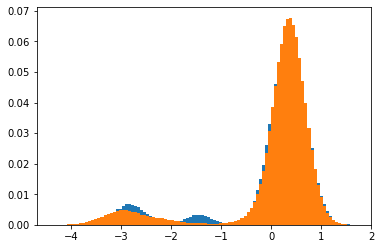

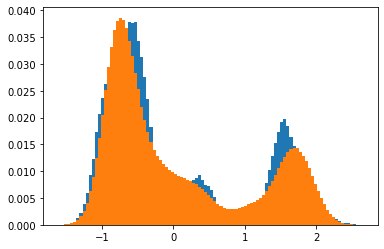

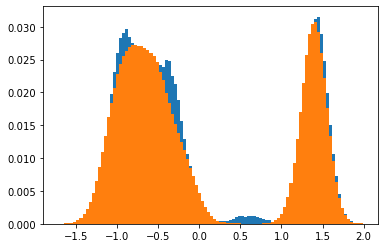

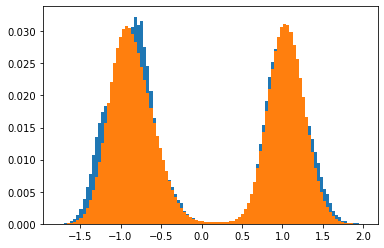

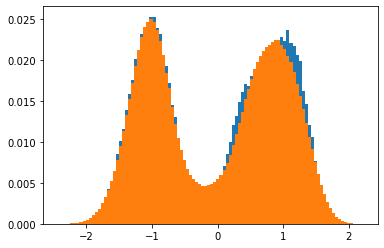

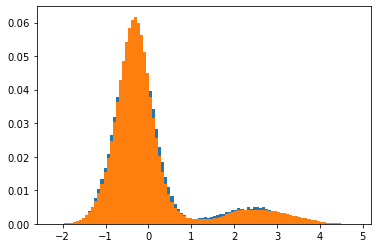

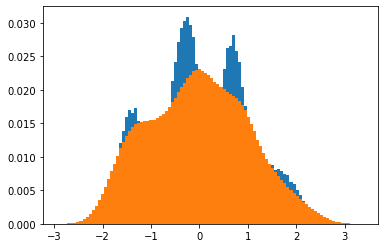

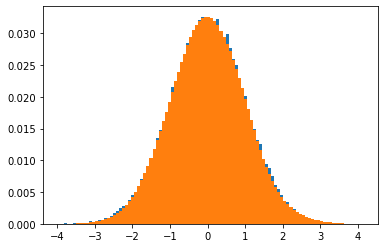

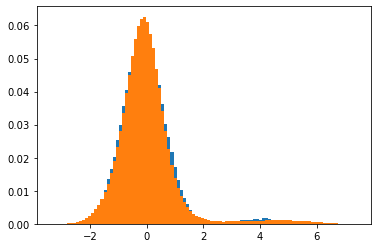

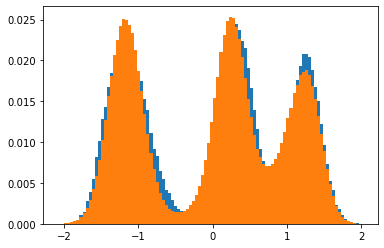

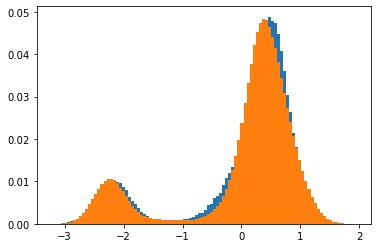

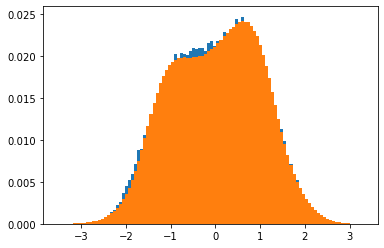

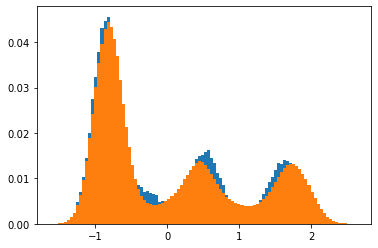

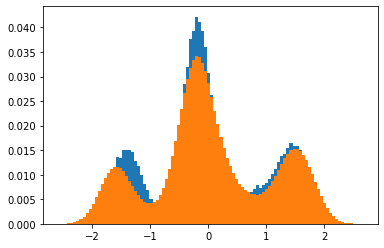

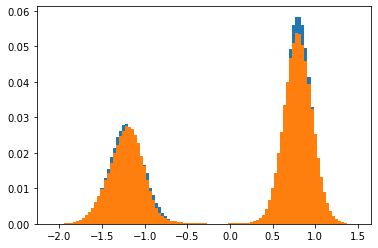

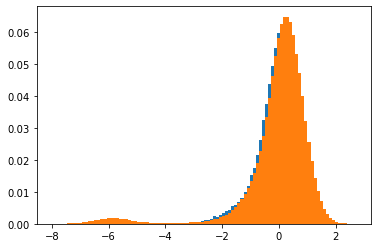

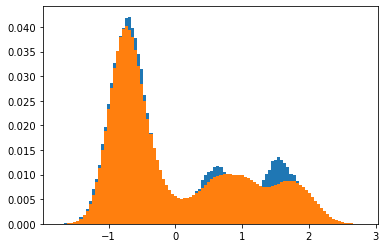

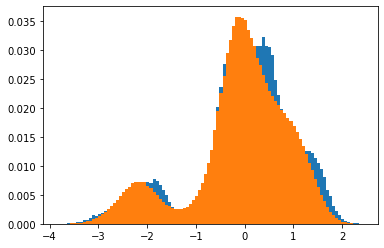

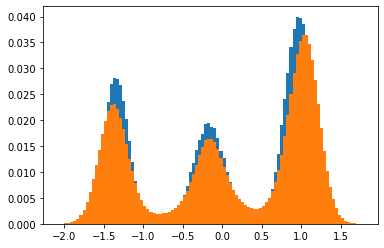

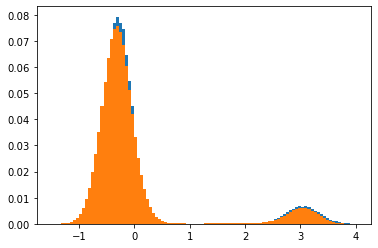

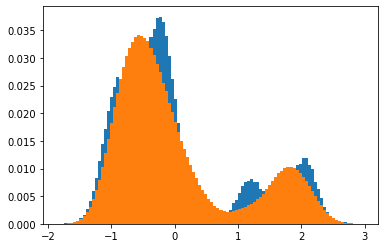

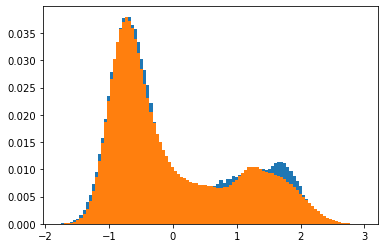

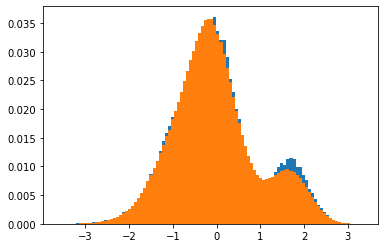

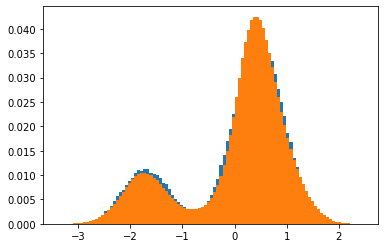

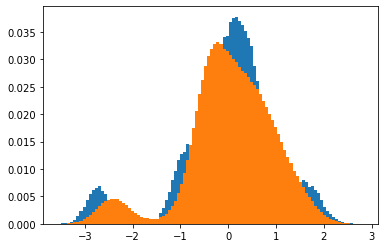

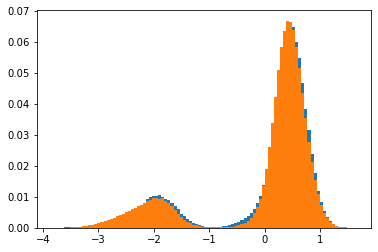

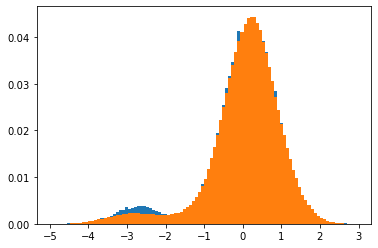

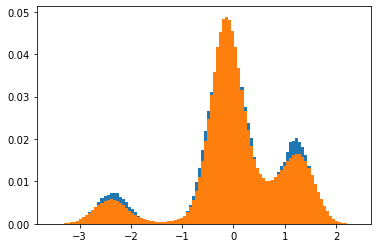

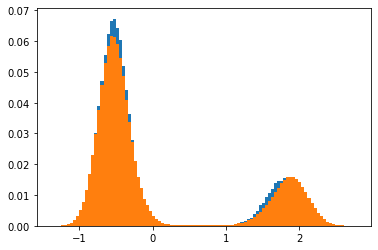

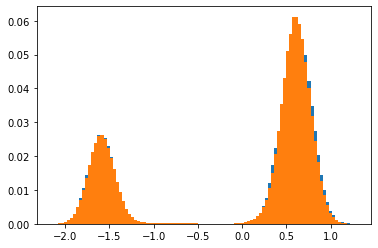

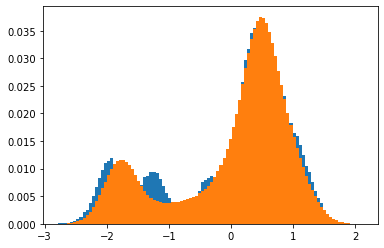

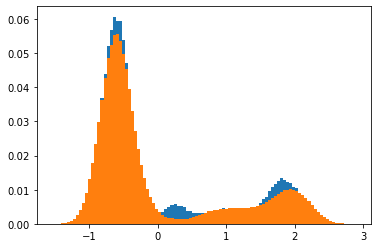

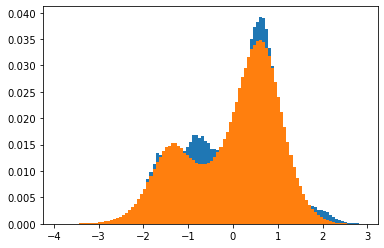

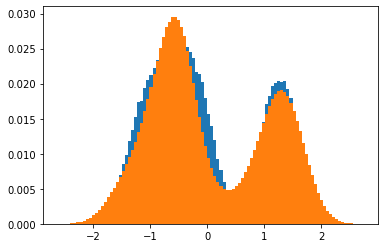

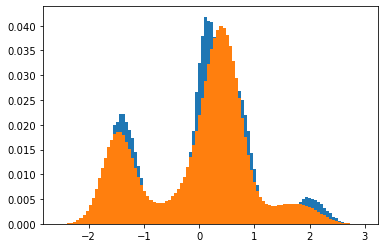

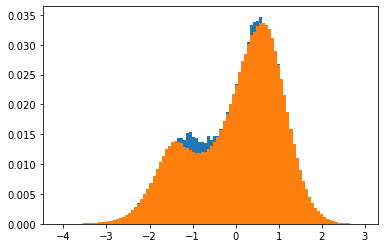

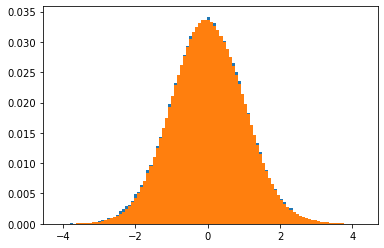

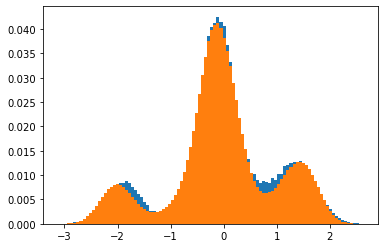

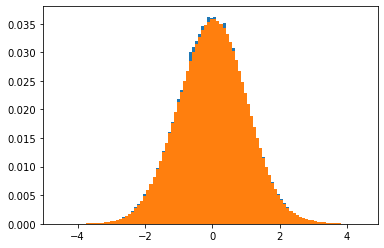

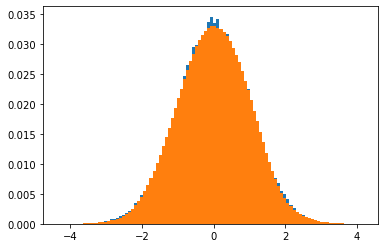

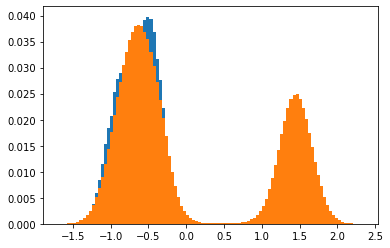

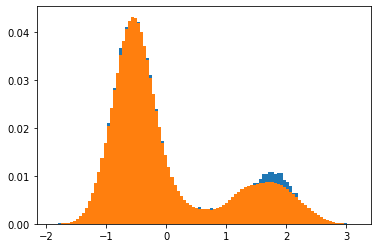

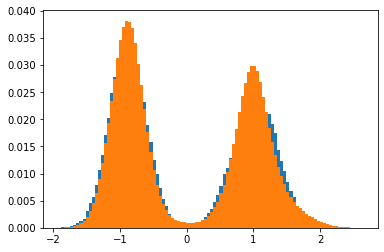

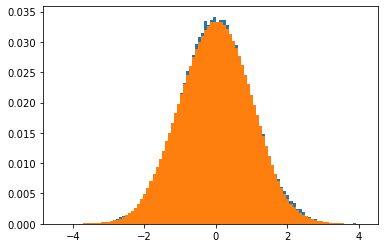

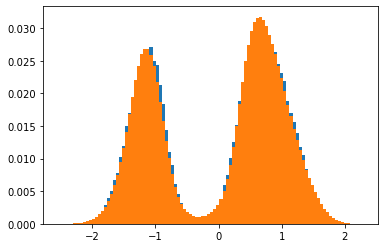

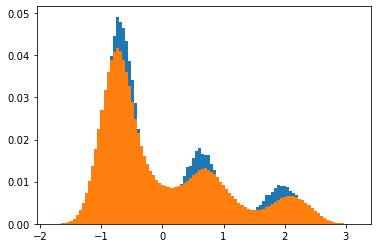

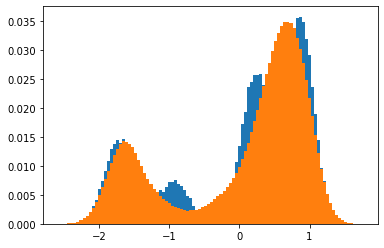

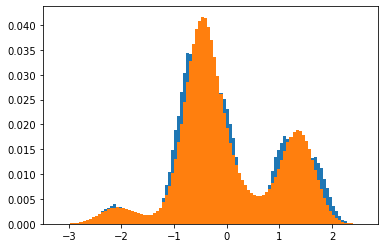

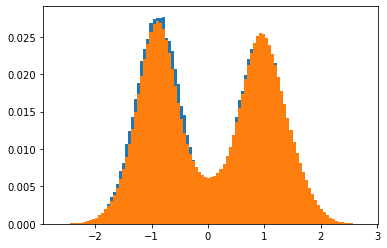

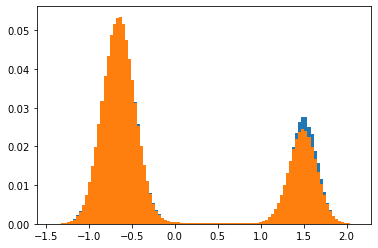

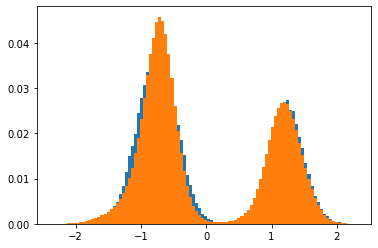

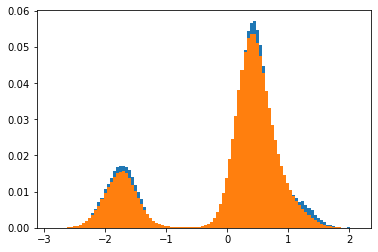

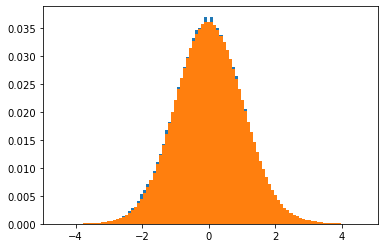

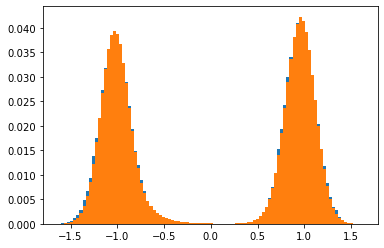

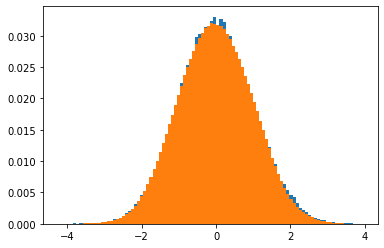

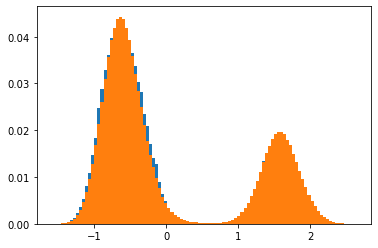

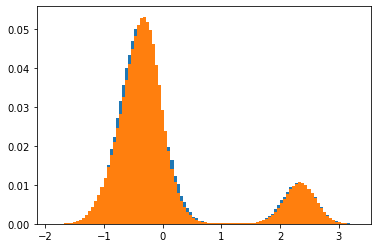

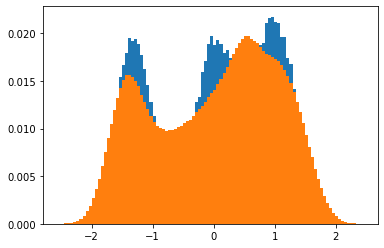

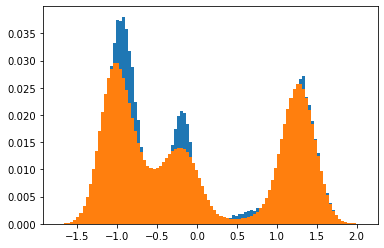

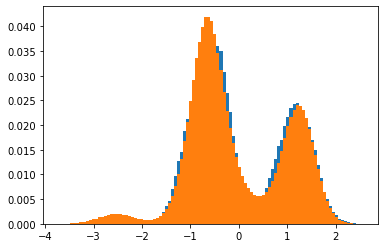

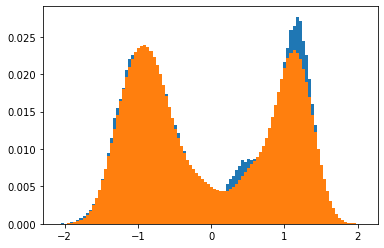

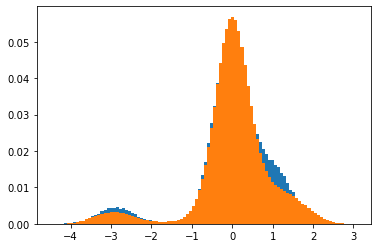

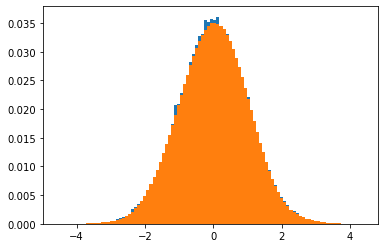

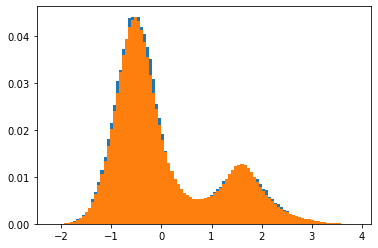

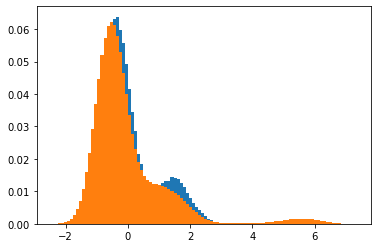

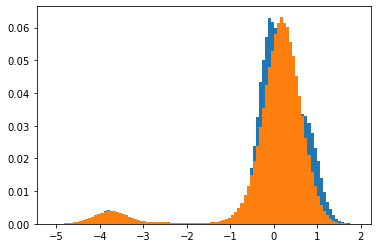

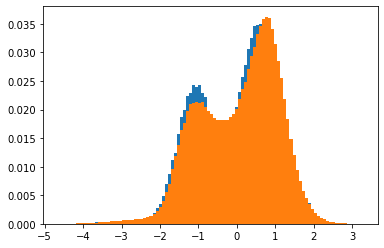

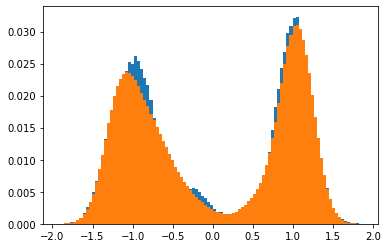

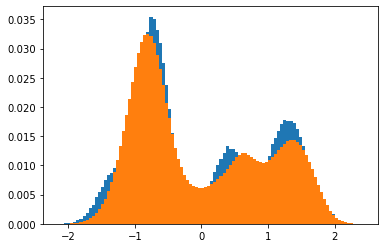

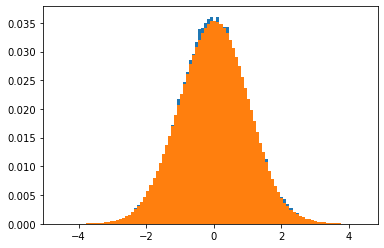

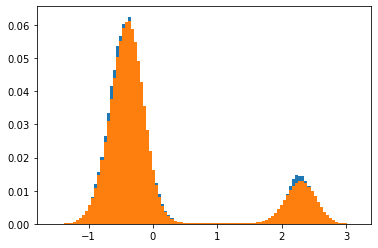

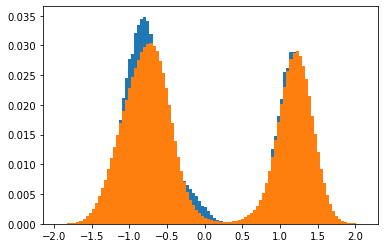

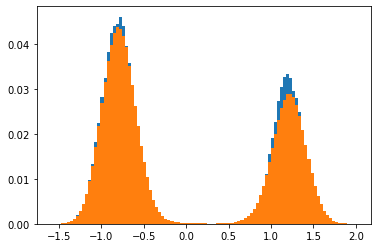

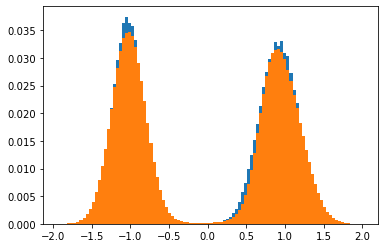

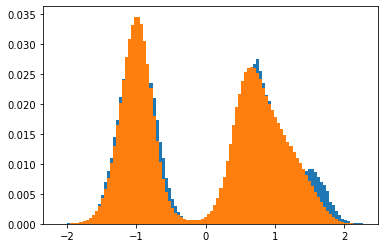

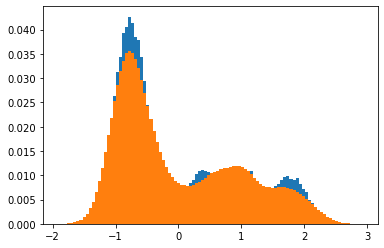

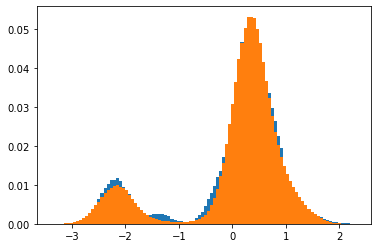

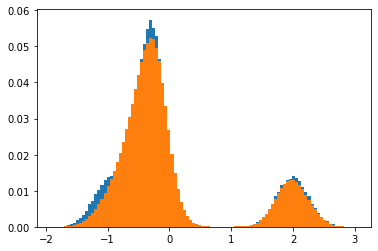

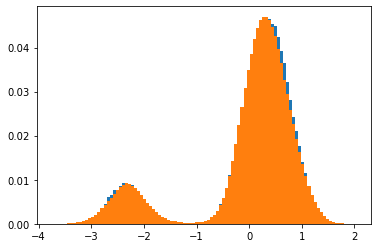

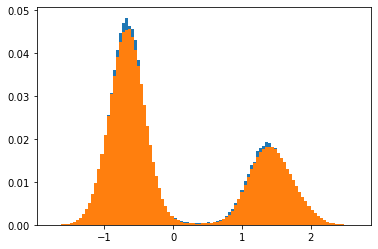

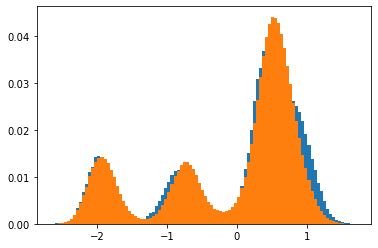

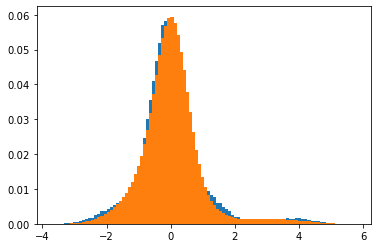

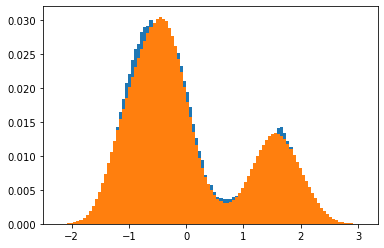

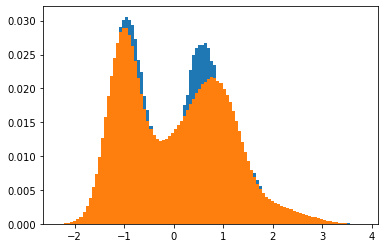

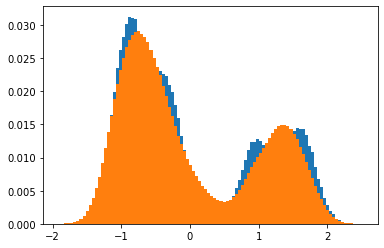

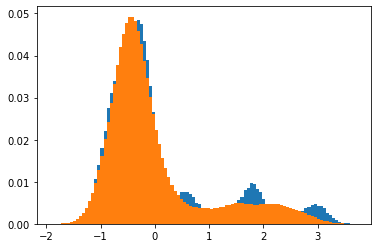

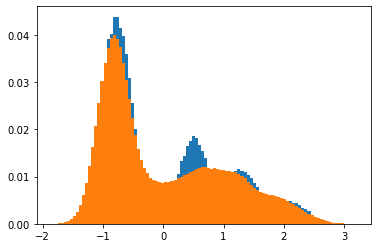

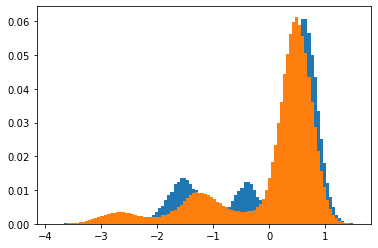

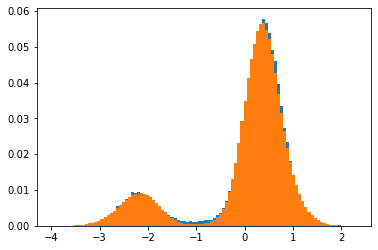

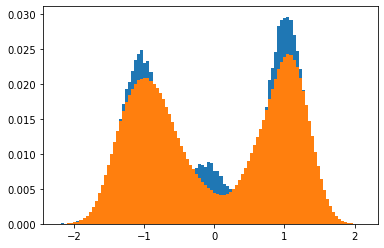

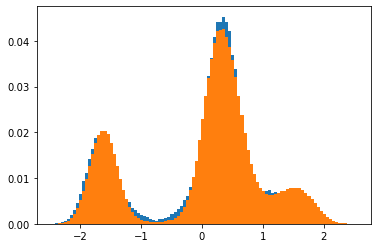

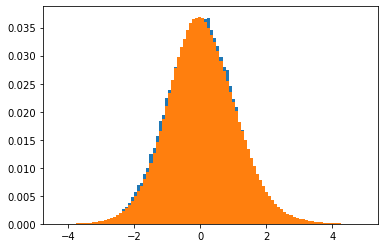

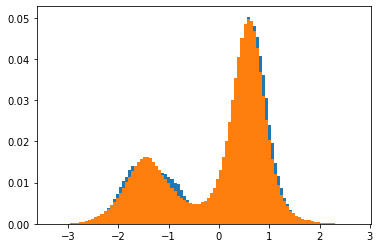

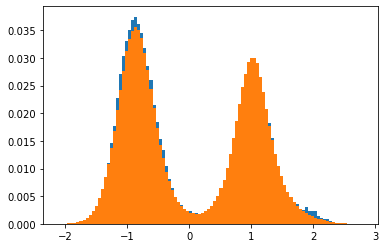

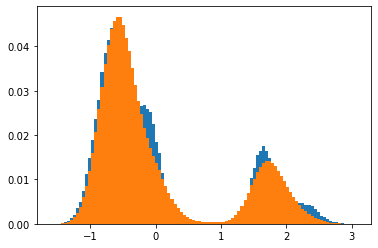

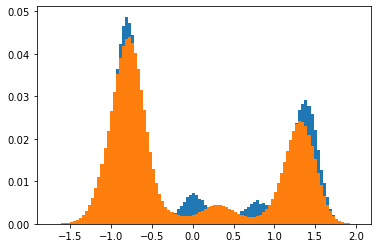

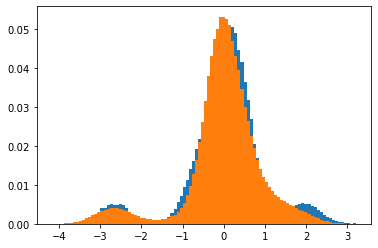

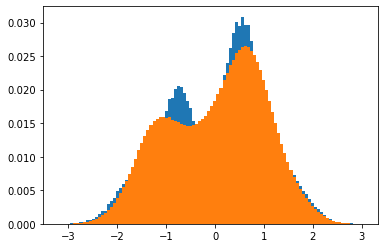

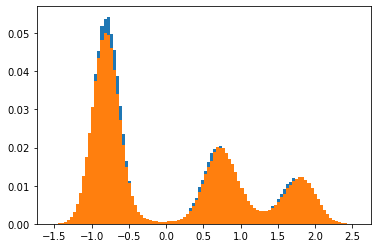

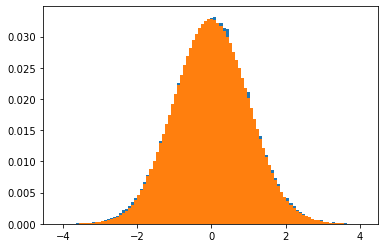

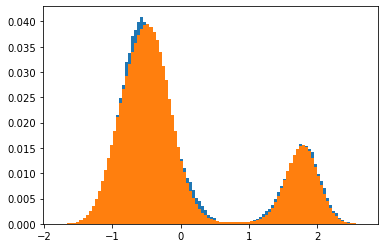

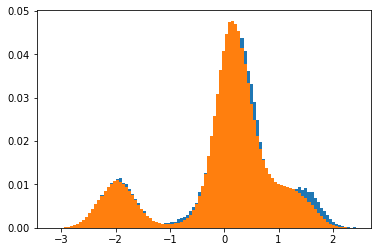

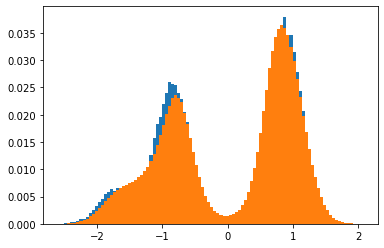

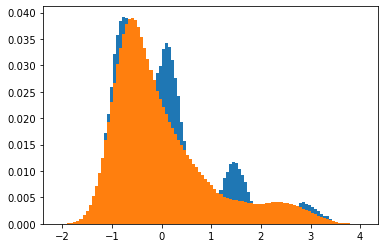

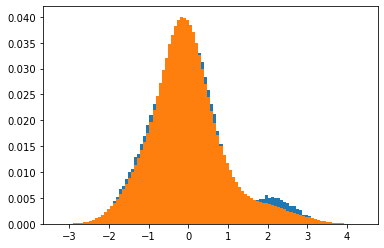

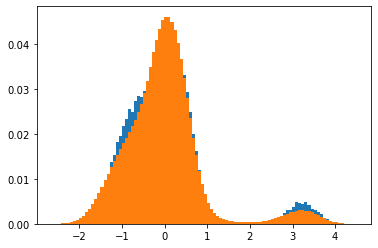

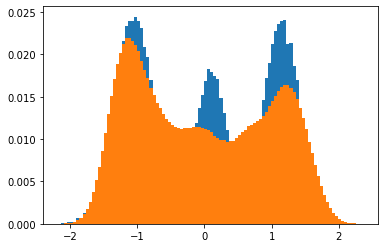

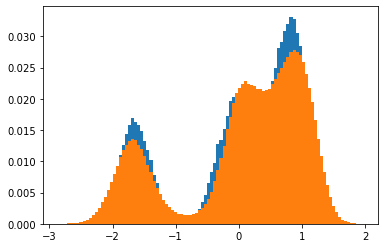

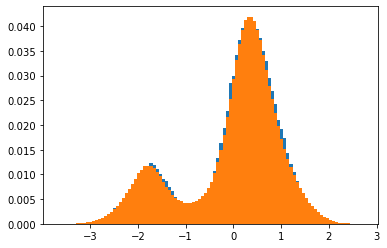

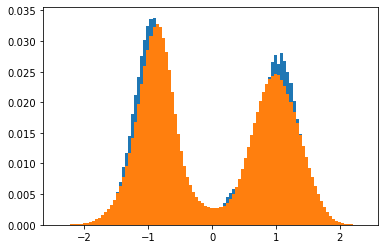

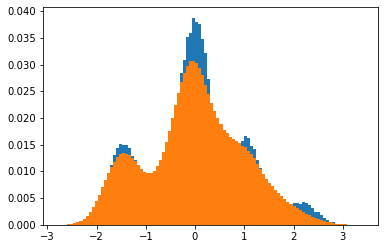

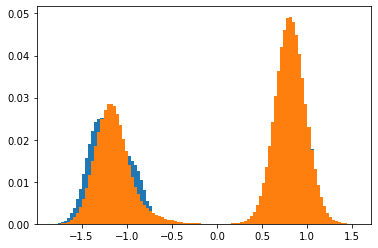

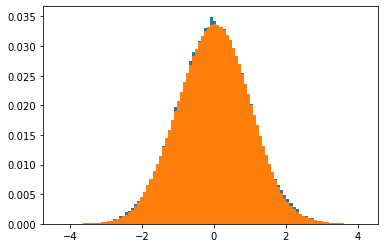

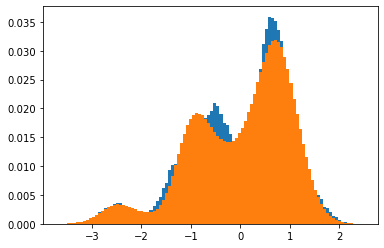

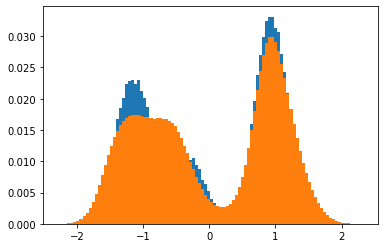

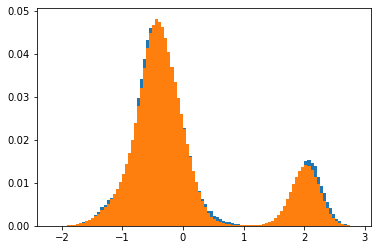

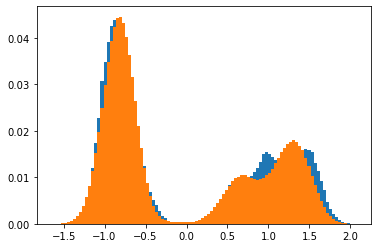

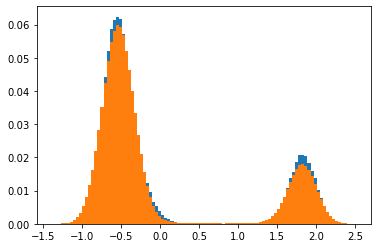

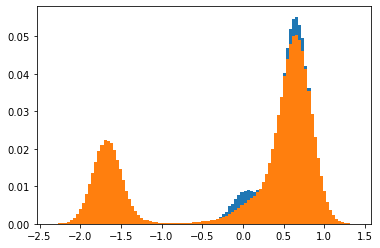

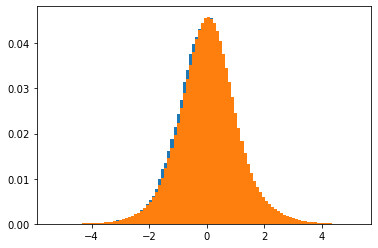

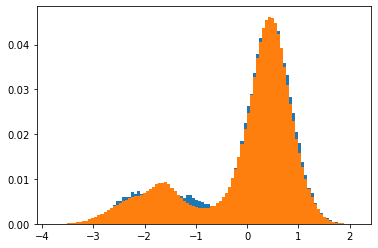

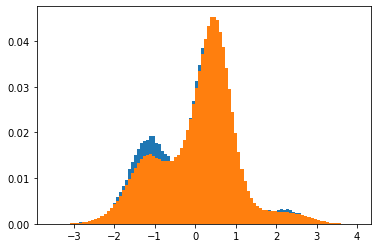

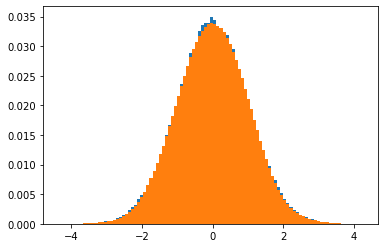

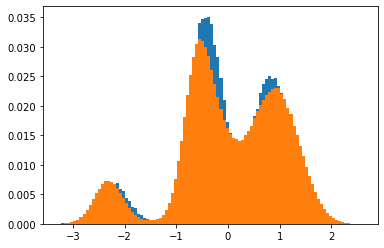

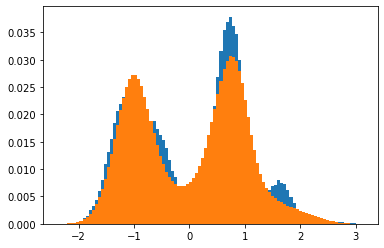

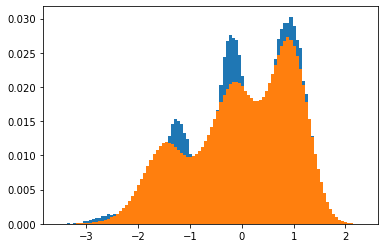

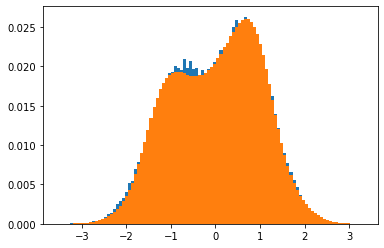

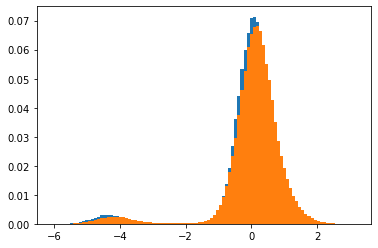

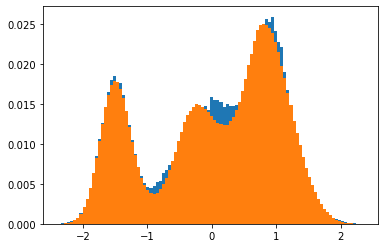

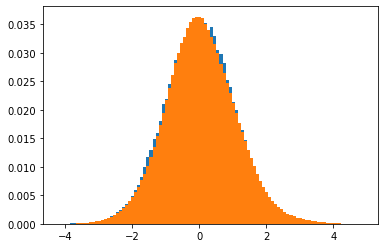

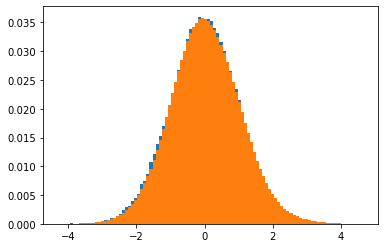

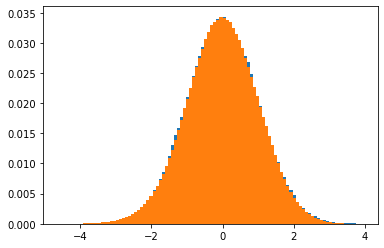

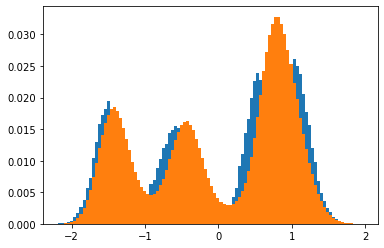

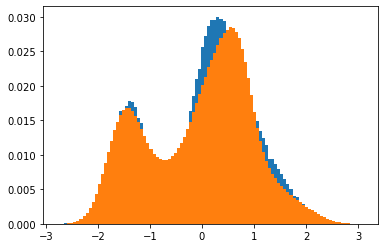

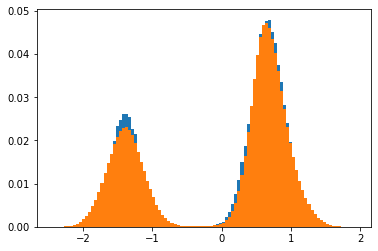

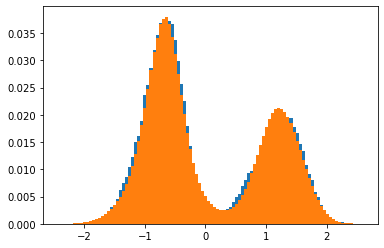

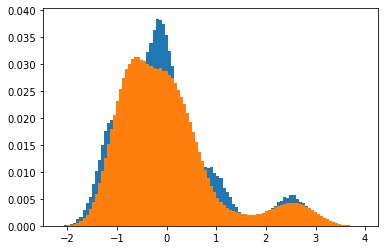

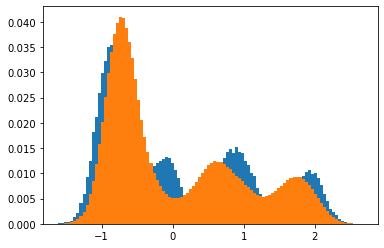

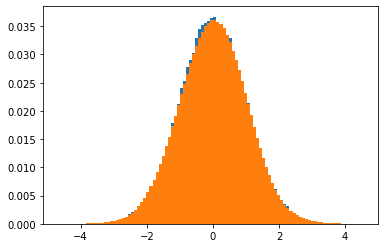

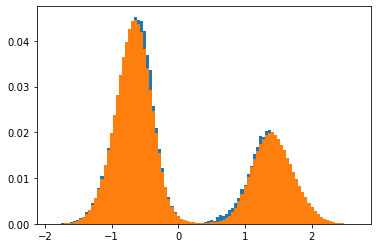

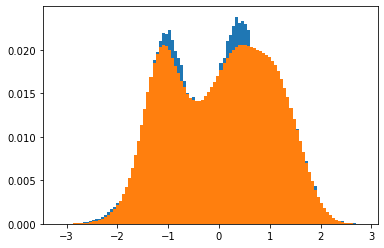

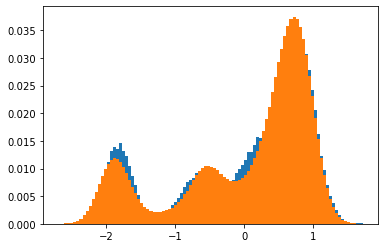

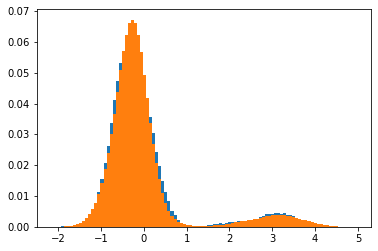

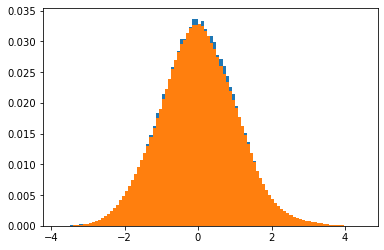

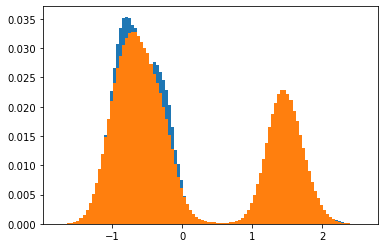

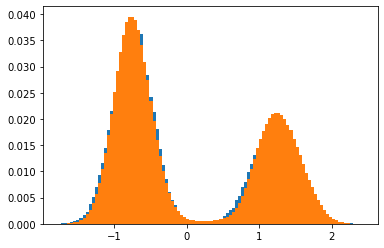

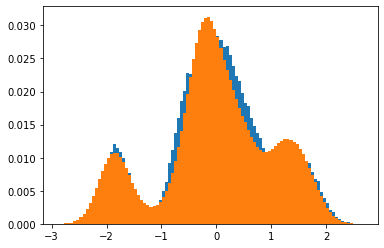

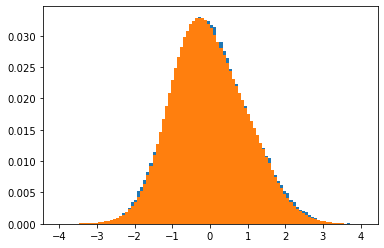

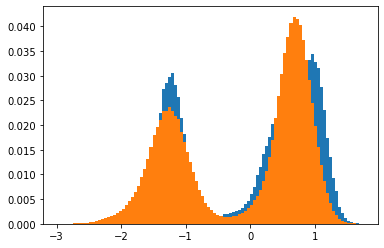

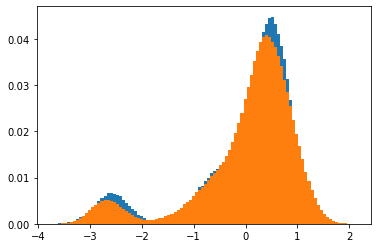

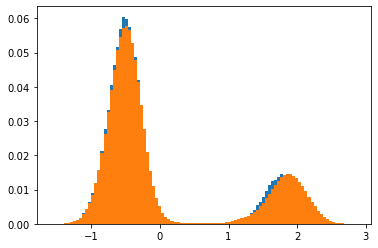

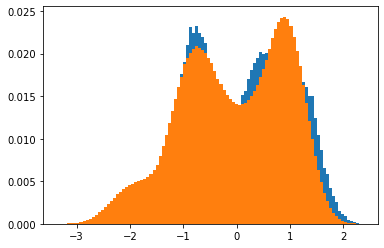

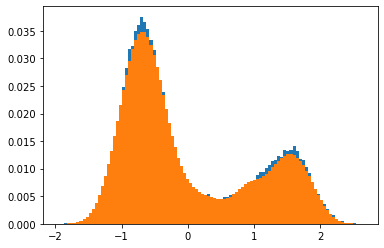

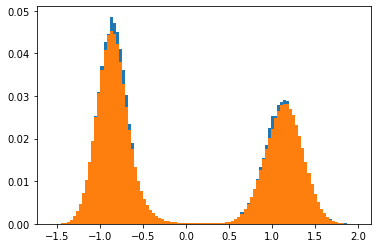

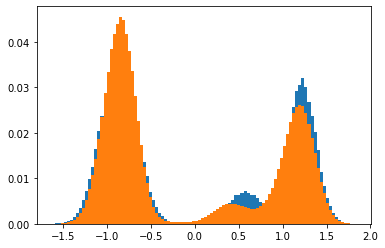

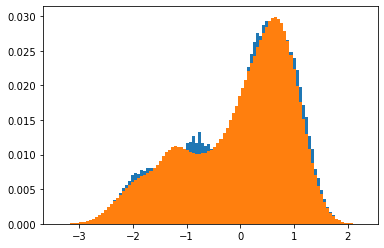

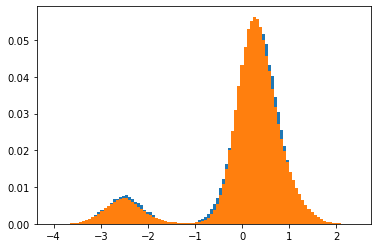

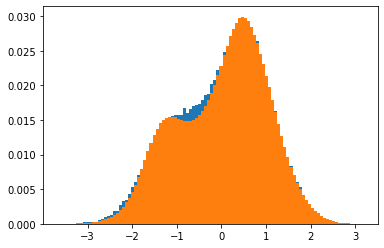

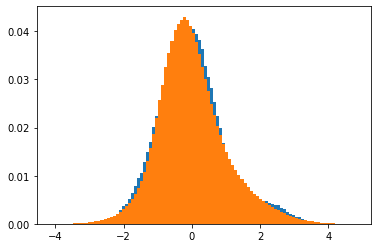

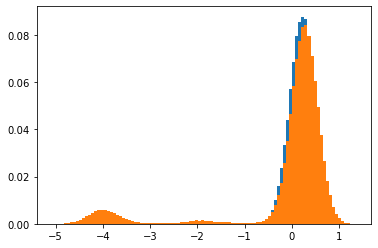

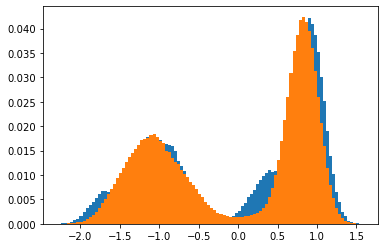

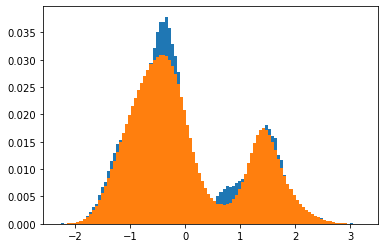

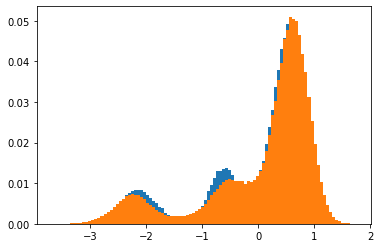

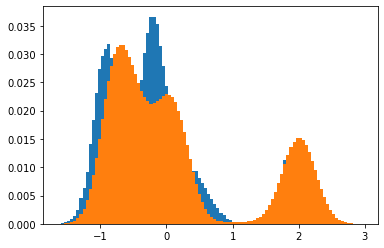

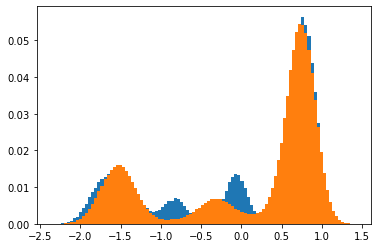

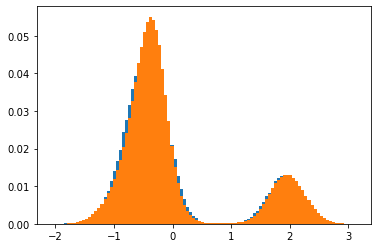

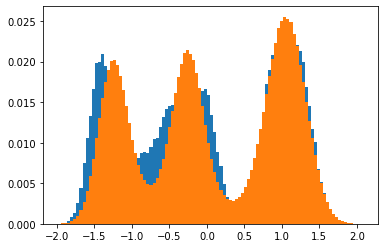

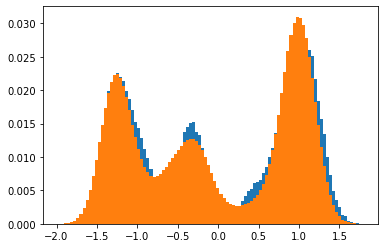

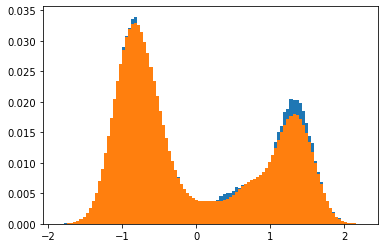

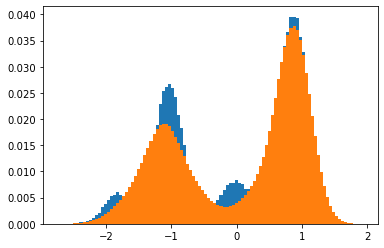

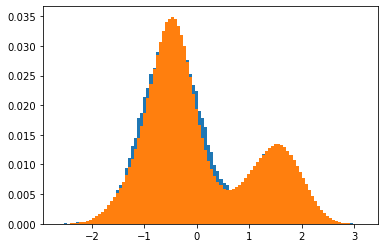

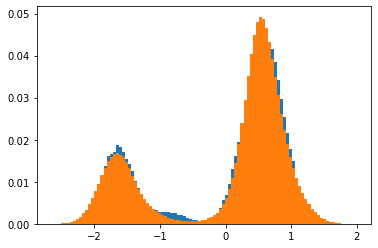

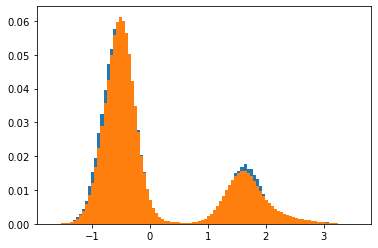

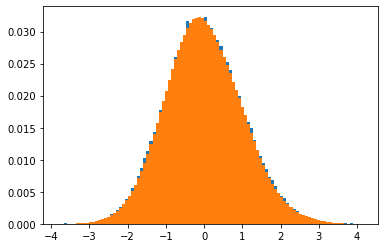

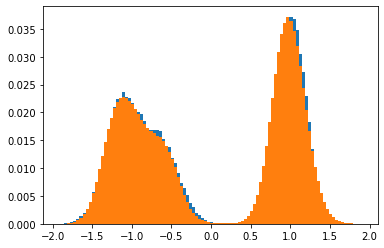

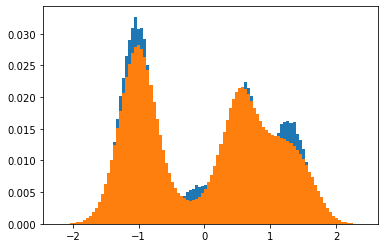

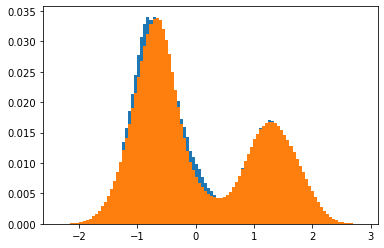

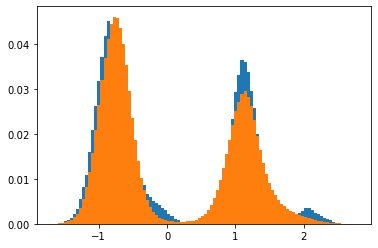

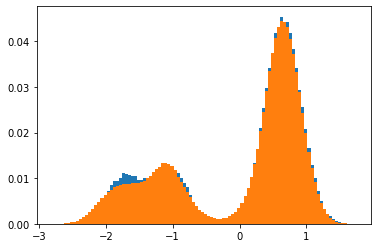

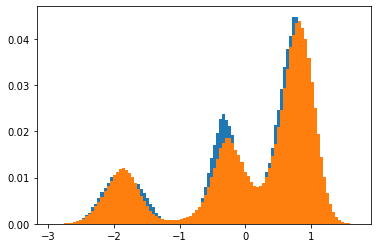

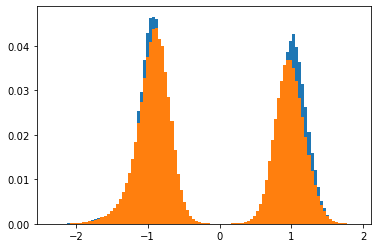

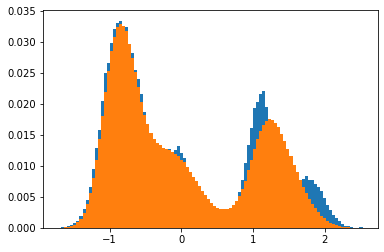

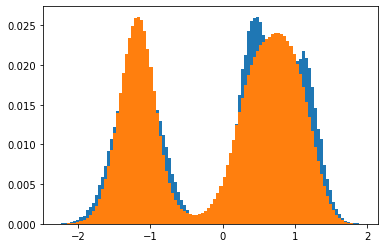

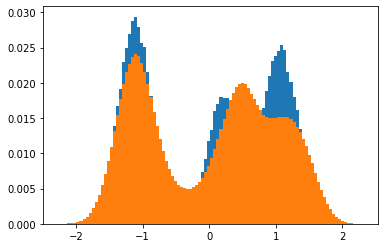

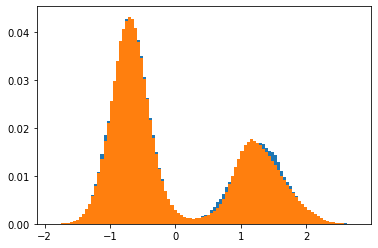

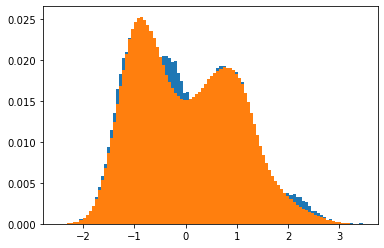

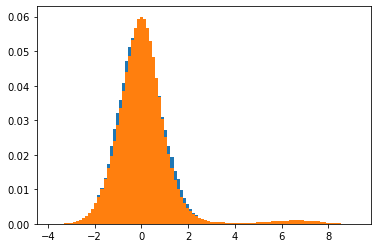

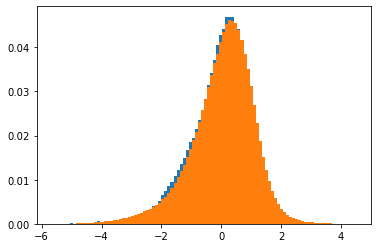

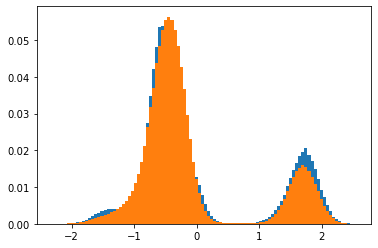

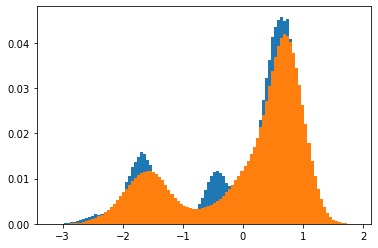

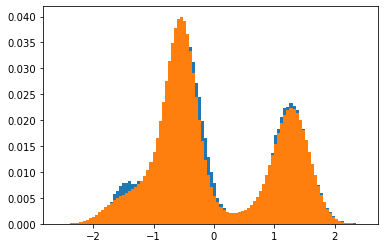

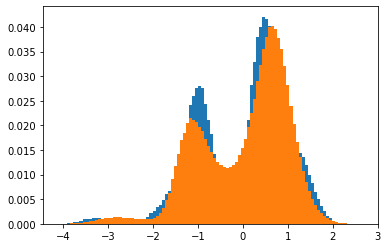

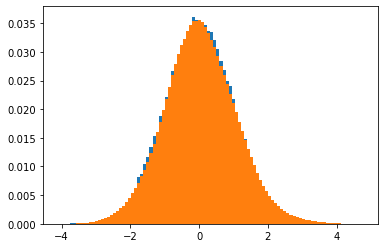

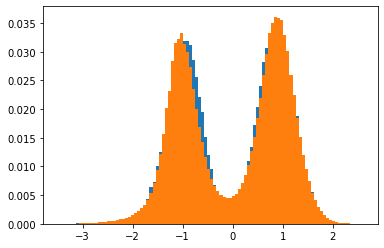

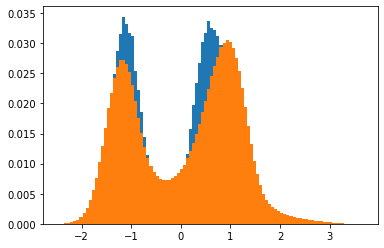

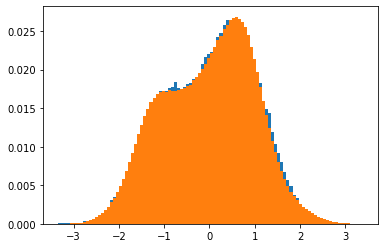

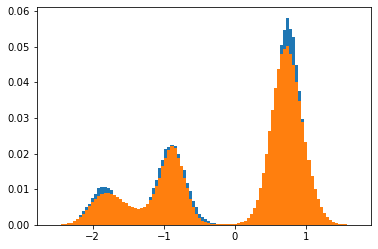

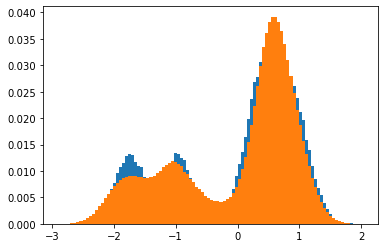

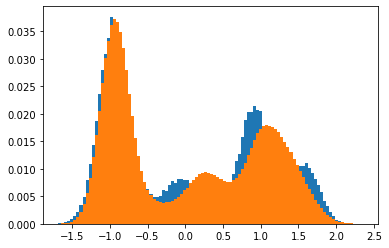

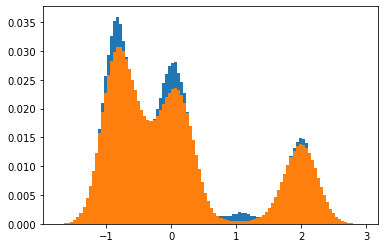

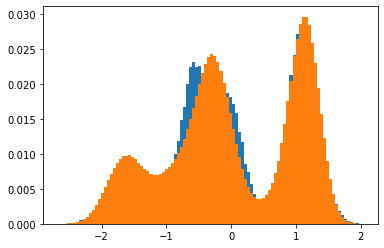

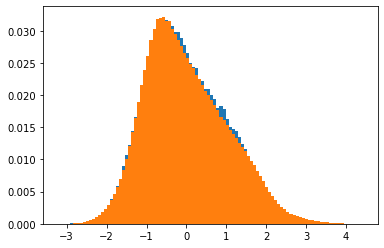

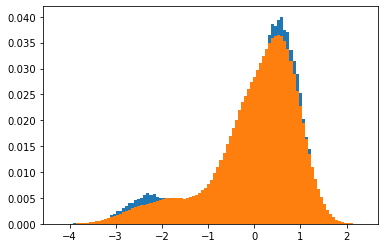

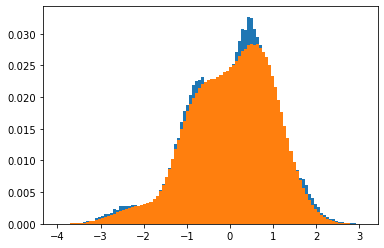

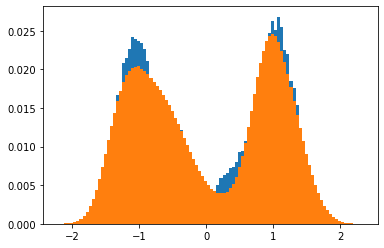

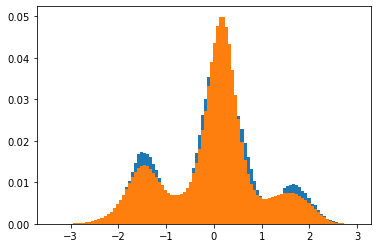

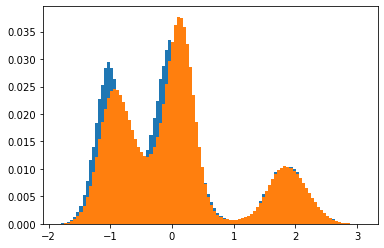

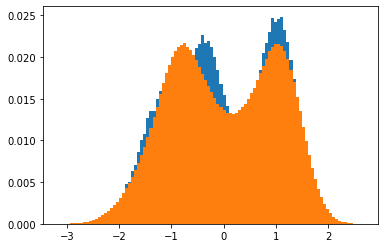

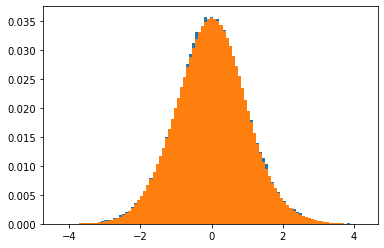

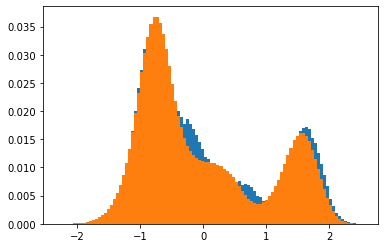

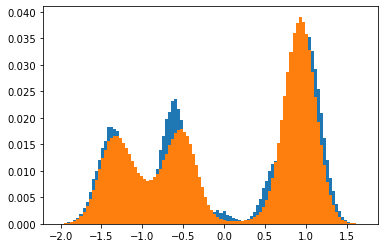

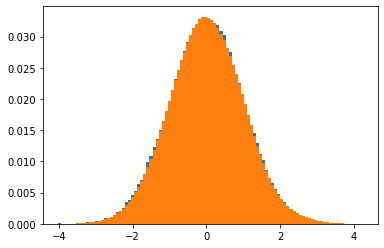

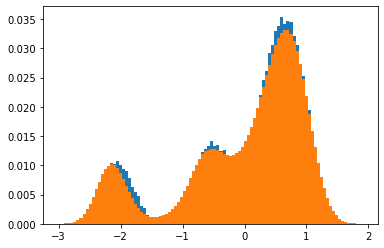

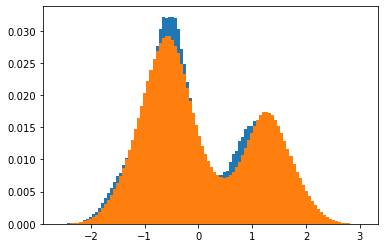

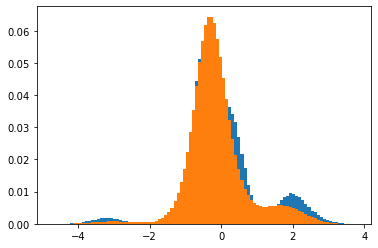

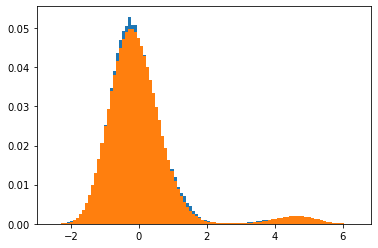

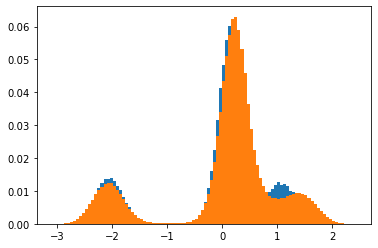

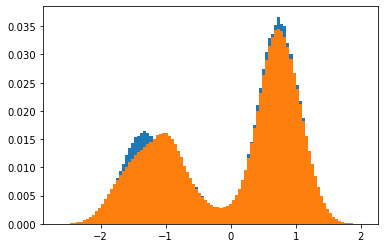

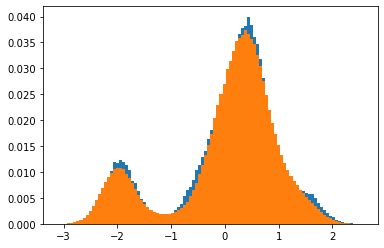

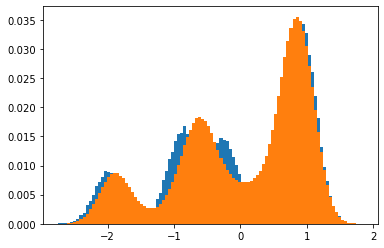

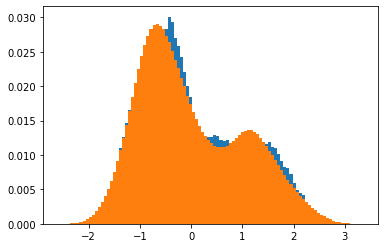

KeyboardInterrupt: 

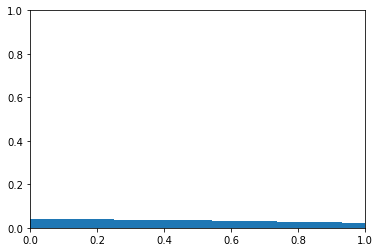

In [146]:
test_pred = net(test_data)

for i in range(1000):
    
    test_edges_ = test_edges[i][:-1]
    edge_width = test_edges_[1] - test_edges_[0]

    plt.bar(test_edges_, test_data[i].cpu(), align='edge', width = edge_width)
    plt.bar(test_edges_, test_pred[i].detach().cpu(), align='edge', width = edge_width)
    plt.show() 
    